In [2]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from TCFile import TCFile
from torchvision import models
import matplotlib.pyplot as plt

In [3]:
import utils
from torch_tomogram_dataset import augmentation_transform_2d
from torch_tomogram_dataset.utils import calculate_edge_mean_2d
import cv2

class Hata(Dataset):
    def __init__(self, root_dir, mode='qpi', 
                 live_time=(0,1), dead_time=(34, 35), crop_size=(480, 480), 
                 sparsity_check=True, transform=None, augmentation=False):
        super().__init__()
        self.root_dir = root_dir
        self.mode = mode.lower()
        self.live_dead_time = {'live':live_time, 'dead':dead_time}
        self.crop_size = crop_size
        self.sparsity_check = sparsity_check
        self.transform = transform
        self.augmentation = augmentation
        self.samples = []
        self.data = []
        self.labels = []
        
        # Sparsity check
        sparsity_model = models.resnet50()
        num_features = sparsity_model.fc.in_features
        sparsity_model.fc = torch.nn.Sequential(
            torch.nn.Dropout(0.2),
            torch.nn.Linear(num_features, 2)
        )
        sparsity_model.load_state_dict(torch.load('sparsity_check.pth'))
        sparsity_model.eval()
        
        # Get path list of TCF files
        file_list = utils._get_tcf_list(self.root_dir)
        
        # Crop
        states = ['live', 'dead']
        for file_path in file_list:
            file = TCFile(file_path, '3D')
            for label, state in enumerate(states):
                for time_index in self.live_dead_time[state]:
                    if self.mode=='qpi':
                        slice_2d = np.sum(file[time_index], axis=0) * file.data_resolution[0]
                    elif self.mode=='mip':
                        slice_2d = np.max(file[time_index], axis=0)

                    fy = file.data_resolution[1]/0.1632
                    fx = file.data_resolution[1]/0.1632
                    
                    if fx!=1 and fy!=1:
                        slice_2d = cv2.resize(slice_2d, dsize=(1+int(slice_2d.shape[0]*fy), 1+int(slice_2d.shape[0]*fx)))
                    
                    patches = utils.crop_patch(slice_2d, crop_size=self.crop_size)        
                    for patch in patches:
                        if utils.sparsity_check(sparsity_model, slice_2d, patch, self.crop_size):
                            top = patch[0]
                            left = patch[1]
                            self.samples.append({'file_path':file_path, 'time_index':time_index, 
                                                 'top':top, 'left':left})
                            self.data.append(slice_2d[top:top+self.crop_size[0], left:left+self.crop_size[1]])
                            self.labels.append(label)
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        # load from memory
        image = self.data[idx]
        # Min-max normalization (float64 -> uint8) : like png file
        image = utils.image_normalization(image)
        # Convert to torch tensor
        image_tensor = torch.from_numpy(image).float().unsqueeze(0).repeat(3,1,1)
        
        # transform
        if self.transform:
            image_tensor = self.transform(image_tensor)
        
        # Rotation with edge mean filling
        if self.augmentation:
            edge_mean = calculate_edge_mean_2d(image_tensor)
            image_tensor = augmentation_transform_2d(image_tensor)
            image_tensor[image_tensor==0] = edge_mean
            
        return image_tensor, self.labels[idx]

In [24]:
from torchvision import models
from torch_tomogram_dataset.augmented_dataset_wrapper import AugmentedDatasetWrapper

mode = 'qpi'
train_dir = r"C:\rkka_Projects\cell_death_v1\Data\Hela_Segmentation_test_PWS\TCF"
test_dir = r"C:\rkka_Projects\cell_death_v1\Data\Hela_Segmentation_test_PWS\TCF\test"
transform = models.ResNet101_Weights.IMAGENET1K_V2.transforms()

train_dataset = Hata(root_dir=train_dir, mode=mode, transform=transform, augmentation=True)
augmented_train_dataset = AugmentedDatasetWrapper(train_dataset, num_repeats=5)

val_dataset = Hata(root_dir=test_dir, mode=mode, transform=transform)

# Define data loaders
batch_size = 16  # Adjust batch size as needed
train_loader = DataLoader(augmented_train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

C:\Users\김민욱\AppData\Local\Temp\ipykernel_23160\3146124278.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sparsity_model.load_state_dict(torch.load('sparsity_check.pth

In [1]:
model = models.resnet101(pretrained=True)
num_features = model.fc.in_features
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.2),
    torch.nn.Linear(num_features, 2)
)

for name, param in model.named_parameters():
    if 'layer4' in name or 'fc' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

utils.trainable_parameters(model)

NameError: name 'models' is not defined

In [34]:
model = model.cuda()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4)

In [35]:
from tqdm import tqdm

# Train
num_epochs = 20

for epoch in tqdm(range(num_epochs)):
    # train
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.cuda(), labels.cuda()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs, 1)
        train_correct += (preds==labels).sum().item()
        train_total += len(labels)
    
    #validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.cuda(), labels.cuda()
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss
            
            _, preds = torch.max(outputs, 1)
            val_correct += (preds==labels).sum().item()
            val_total += len(labels)
            
    torch.save(model.state_dict(), f'{mode}_epoch_{epoch}_val_acc_{val_correct/val_total:.4f}_assay_model.pth')
            
    print(f"Epoch : {epoch}")
    print(f"train loss : {train_loss/train_total:.6f} || train_acc : {train_correct/train_total:.4f}")
    print(f"val loss : {val_loss/val_total:.6f} || val_acc : {val_correct/val_total:.4f}")
    

  5%|▌         | 1/20 [00:09<02:53,  9.13s/it]

Epoch : 0
train loss : 0.003716 || train_acc : 0.9784
val loss : 0.001810 || val_acc : 0.9898


 10%|█         | 2/20 [00:18<02:50,  9.48s/it]

Epoch : 1
train loss : 0.001111 || train_acc : 0.9936
val loss : 0.001861 || val_acc : 0.9873


 15%|█▌        | 3/20 [00:28<02:43,  9.65s/it]

Epoch : 2
train loss : 0.000743 || train_acc : 0.9963
val loss : 0.003688 || val_acc : 0.9822


 20%|██        | 4/20 [00:38<02:35,  9.71s/it]

Epoch : 3
train loss : 0.002333 || train_acc : 0.9977
val loss : 0.004924 || val_acc : 0.9847


 25%|██▌       | 5/20 [00:48<02:26,  9.74s/it]

Epoch : 4
train loss : 0.000669 || train_acc : 0.9968
val loss : 0.003227 || val_acc : 0.9873


 30%|███       | 6/20 [00:58<02:16,  9.73s/it]

Epoch : 5
train loss : 0.000357 || train_acc : 0.9977
val loss : 0.003441 || val_acc : 0.9898


 35%|███▌      | 7/20 [01:07<02:06,  9.70s/it]

Epoch : 6
train loss : 0.000396 || train_acc : 0.9986
val loss : 0.001306 || val_acc : 0.9924


 40%|████      | 8/20 [01:17<01:56,  9.73s/it]

Epoch : 7
train loss : 0.000738 || train_acc : 0.9968
val loss : 0.003424 || val_acc : 0.9898


 45%|████▌     | 9/20 [01:27<01:47,  9.75s/it]

Epoch : 8
train loss : 0.000352 || train_acc : 0.9986
val loss : 0.002522 || val_acc : 0.9898


 50%|█████     | 10/20 [01:36<01:37,  9.74s/it]

Epoch : 9
train loss : 0.000109 || train_acc : 0.9995
val loss : 0.002197 || val_acc : 0.9924


 55%|█████▌    | 11/20 [01:46<01:27,  9.75s/it]

Epoch : 10
train loss : 0.001400 || train_acc : 0.9991
val loss : 0.002575 || val_acc : 0.9898


 60%|██████    | 12/20 [01:56<01:18,  9.78s/it]

Epoch : 11
train loss : 0.001845 || train_acc : 0.9908
val loss : 0.002536 || val_acc : 0.9949


 65%|██████▌   | 13/20 [02:06<01:08,  9.78s/it]

Epoch : 12
train loss : 0.000186 || train_acc : 0.9995
val loss : 0.002645 || val_acc : 0.9924


 70%|███████   | 14/20 [02:16<00:58,  9.75s/it]

Epoch : 13
train loss : 0.000069 || train_acc : 1.0000
val loss : 0.003049 || val_acc : 0.9924


 75%|███████▌  | 15/20 [02:25<00:48,  9.77s/it]

Epoch : 14
train loss : 0.000034 || train_acc : 1.0000
val loss : 0.002807 || val_acc : 0.9898


 80%|████████  | 16/20 [02:35<00:39,  9.80s/it]

Epoch : 15
train loss : 0.000149 || train_acc : 0.9995
val loss : 0.003000 || val_acc : 0.9924


 85%|████████▌ | 17/20 [02:45<00:29,  9.79s/it]

Epoch : 16
train loss : 0.001399 || train_acc : 0.9986
val loss : 0.002239 || val_acc : 0.9898


 90%|█████████ | 18/20 [02:55<00:19,  9.80s/it]

Epoch : 17
train loss : 0.000555 || train_acc : 0.9968
val loss : 0.004249 || val_acc : 0.9847


 95%|█████████▌| 19/20 [03:05<00:09,  9.80s/it]

Epoch : 18
train loss : 0.000147 || train_acc : 0.9995
val loss : 0.002904 || val_acc : 0.9898


100%|██████████| 20/20 [03:14<00:00,  9.75s/it]

Epoch : 19
train loss : 0.000047 || train_acc : 1.0000
val loss : 0.002855 || val_acc : 0.9898


In [12]:
torch.save(model.state_dict(), 'mip_assay_model.pth')

In [22]:
from torchvision import models
from torch_tomogram_dataset.augmented_dataset_wrapper import AugmentedDatasetWrapper

mode = 'qpi'
new_dir = r"C:\rkka_Projects\cell_death_v1\Data\Hela_Segmentation_test_PWS\TCF\test"
transform = models.ResNet101_Weights.IMAGENET1K_V2.transforms()

dataset = Hata(root_dir=new_dir, mode=mode, transform=transform, augmentation=False)

# Define data loaders
batch_size = 16  # Adjust batch size as needed
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

C:\Users\김민욱\AppData\Local\Temp\ipykernel_23160\3146124278.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sparsity_model.load_state_dict(torch.load('sparsity_check.pth

In [39]:
model = models.resnet101(pretrained=True)
num_features = model.fc.in_features
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.2),
    torch.nn.Linear(num_features, 2)
)
model.load_state_dict(torch.load('qpi_epoch_9_val_acc_0.9924_assay_model.pth'))
model = model.cuda()

c:\miniconda3\envs\cell\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\miniconda3\envs\cell\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\김민욱\AppData\Local\Temp\ipykernel_23160\421947838.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.

In [40]:
#validation
model.eval()
val_loss, val_correct, val_total = 0, 0, 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.cuda(), labels.cuda()
            
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss
            
        _, preds = torch.max(outputs, 1)
        val_correct += (preds==labels).sum().item()
        val_total += len(labels)
        
print(f"Validation loss : {val_loss/val_total:.6f}")
print(f"Validation accuracy : {val_correct/val_total:.4f}")

Validation loss : 0.002197
Validation accuracy : 0.9924


In [42]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.cuda(), labels.cuda()

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

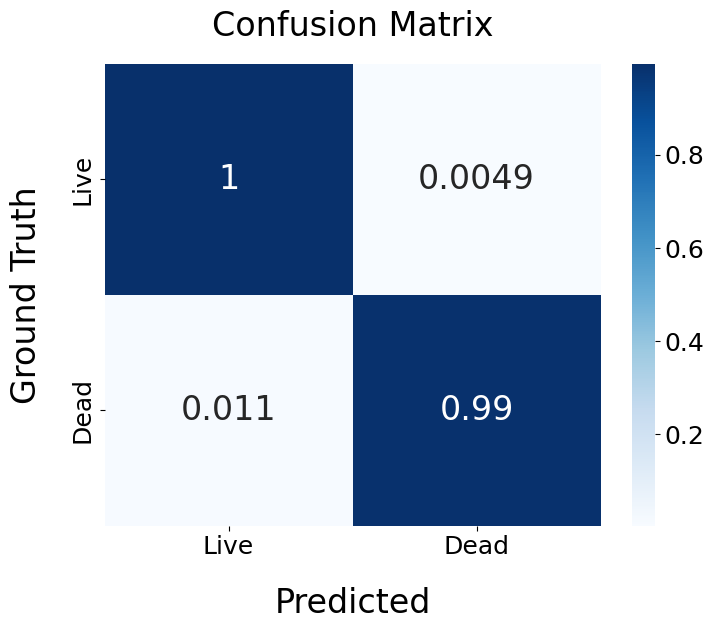

In [43]:
# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_preds, normalize='true')

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=["Live", "Dead"], yticklabels=["Live", "Dead"], annot_kws={'size': 24})
plt.xlabel("Predicted", fontsize=24, labelpad=20)
plt.ylabel("Ground Truth", fontsize=24, labelpad=20)
plt.title("Confusion Matrix", fontsize=24, pad=20)

# Adjust colorbar font size
cbar = plt.gca().collections[0].colorbar
cbar.ax.tick_params(labelsize=18)  # Set colorbar tick font size

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.savefig('figures/figure3/confusion_matrix.svg', format='svg', transparent=True)
plt.show()

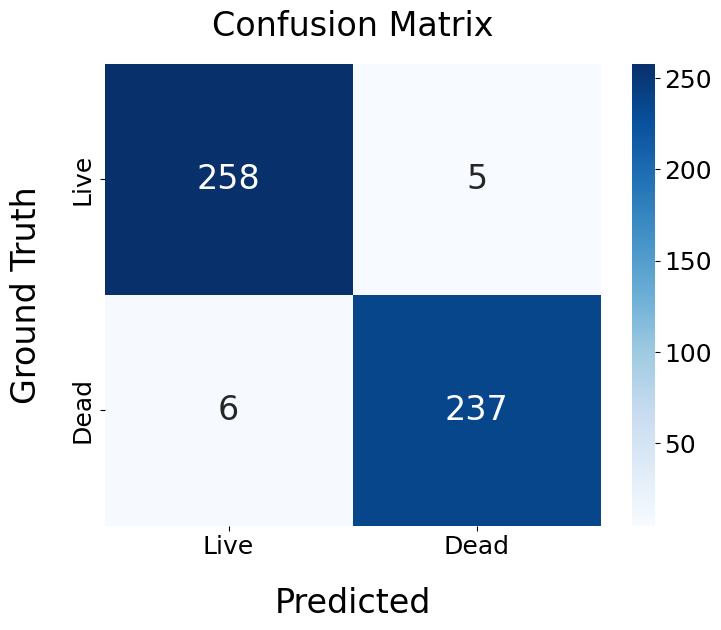

In [44]:
# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Live", "Dead"], yticklabels=["Live", "Dead"], annot_kws={'size': 24})
plt.xlabel("Predicted", fontsize=24, labelpad=20)
plt.ylabel("Ground Truth", fontsize=24, labelpad=20)
plt.title("Confusion Matrix", fontsize=24, pad=20)

# Adjust colorbar font size
cbar = plt.gca().collections[0].colorbar
cbar.ax.tick_params(labelsize=18)  # Set colorbar tick font size

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.show()

<h1> TimeLapse </h1>

In [44]:
model = models.resnet101()
num_features = model.fc.in_features
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.2),
    torch.nn.Linear(num_features, 2)
)
model.load_state_dict(state_dict=torch.load('qpi_assay_model.pth'))
model = model.cuda()

transform = models.ResNet101_Weights.IMAGENET1K_V2.transforms()

C:\Users\김민욱\AppData\Local\Temp\ipykernel_23160\1046289840.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(state_dict=torch.load('qpi_assay_model.p

In [27]:
path = r"C:\rkka_Projects\cell_death_v1\Data\Hela_Segmentation_test_PWS\TCF\230510.174730.HeLa_Hoechst.001.Group1.A2.T001P02.TCF"
file = TCFile(path, '3D')
stack = np.array([np.sum(file[time_idx], axis=0) for time_idx in range(len(file))])
stack.shape

c:\miniconda3\envs\cell\Lib\site-packages\TCFile\TCFile_class.py:190: UserWarning: You use an experimental file format deprecated.
Update your reconstruction program and rebuild TCF file.
  warnings.warn(("You use an experimental file format deprecated.\n"


(47, 1009, 1009)

In [ ]:
crop_size = (504, 504)

# Sparsity check
sparsity_model = models.resnet50()
num_features = sparsity_model.fc.in_features
sparsity_model.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.2),
    torch.nn.Linear(num_features, 2)
)
sparsity_model.load_state_dict(torch.load('sparsity_check.pth'))
sparsity_model.eval()

# Good patches
data = []

for t, slice in enumerate(stack):
    patches = utils._crop_patch(slice, crop_size)
    for patch in patches:
        top = patch[0]
        left = patch[1]
        if utils._sparsity_check(sparsity_model, slice, patch, crop_size):
            data.append({'time_index':t, 'slice_patch':slice[top:top+crop_size[0], left:left+crop_size[1]]})

C:\Users\김민욱\AppData\Local\Temp\ipykernel_24076\2448424832.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sparsity_model.load_state_dict(torch.load('sparsity_check.pth

In [34]:
model.eval()
with torch.no_grad():
    probabilities = []
    for time in range(len(stack)):
        t_data = []
        for d in data:
            if d['time_index']==time:
                t_data.append(d['slice_patch'])
        
        N = len(t_data)
        death_probability = 0
        
        output_list = []
        for patch in t_data:
            patch = utils._image_normalization(patch)
            patch = torch.from_numpy(patch).cuda()
            patch = patch.float().unsqueeze(0).repeat(3,1,1)
            patch = transform(patch)
            
            output = model(patch.unsqueeze(0))
            output_prob = torch.nn.functional.softmax(output)
            output_list.append(output_prob[0][1].item())
        
        for o in output_list:
            death_probability += o
        
        death_probability = death_probability/N
        
        probabilities.append(death_probability)

C:\Users\김민욱\AppData\Local\Temp\ipykernel_24456\2911896940.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output_prob = torch.nn.functional.softmax(output)


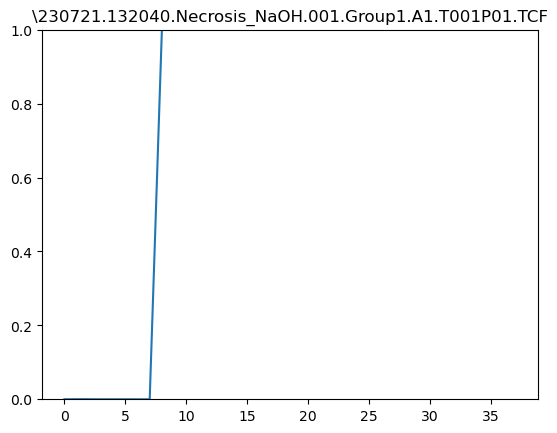

In [35]:
import matplotlib.pyplot as plt

plt.ylim(0,1)
plt.title(path.split('test')[-1])
plt.plot(probabilities)

<h1> Timelapse json </h1>

In [45]:
from tqdm import tqdm
import os
from TCFile import TCFile
import numpy as np
import torch
from torchvision import models
import utils

model = models.resnet101()
num_features = model.fc.in_features
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.2),
    torch.nn.Linear(num_features, 2)
)
model.load_state_dict(state_dict=torch.load('qpi_assay_model.pth'))
model = model.cuda()

transform = models.ResNet101_Weights.IMAGENET1K_V2.transforms()

C:\Users\김민욱\AppData\Local\Temp\ipykernel_23160\3456667119.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(state_dict=torch.load('qpi_assay_model.

In [47]:
li = [0, 1, 2]
for l in li:
    if l==1:
        l=3

li

[0, 1, 2]

In [54]:
root_path =r"C:\rkka_Projects\cell_death_v1\Data\Hela_Segmentation_test_PWS\TCF\live"
total_probabilities = []

for path in tqdm(os.listdir(root_path)):
    if path.endswith('.TCF'):
        file_path = os.path.join(root_path, path)
        file = TCFile(file_path, '3D')
        stack = [np.sum(file[time_idx], axis=0) for time_idx in range(len(file))]

        crop_size = (480, 480)
        fy = file.data_resolution[1]/0.1632
        fx = file.data_resolution[1]/0.1632
        
        if fx!=1 and fy!=1:
            resized_stack = []
            for slice_2d in stack:
                resized_stack.append(cv2.resize(slice_2d, dsize=(1+int(slice_2d.shape[0]*fy), 1+int(slice_2d.shape[0]*fx))))
        else:
            resized_stack = stack

        # Sparsity check
        sparsity_model = models.resnet50()
        num_features = sparsity_model.fc.in_features
        sparsity_model.fc = torch.nn.Sequential(
            torch.nn.Dropout(0.2),
            torch.nn.Linear(num_features, 2)
        )
        sparsity_model.load_state_dict(torch.load('sparsity_check.pth'))
        sparsity_model.eval()

        # Good patches
        data = []

        for t, slice in enumerate(resized_stack):
            patches = utils._crop_patch(slice, crop_size)
            for patch in patches:
                if utils._sparsity_check(sparsity_model, slice, patch, crop_size):
                    top = patch[0]
                    left = patch[1]

                    data.append({'time_index':t, 'slice_patch':slice[top:top+crop_size[0], left:left+crop_size[1]]})
                    
        model.eval()
        with torch.no_grad():
            probabilities = []
            for time in range(len(resized_stack)):
                t_data = []
                for d in data:
                    if d['time_index']==time:
                        t_data.append(d['slice_patch'])
                
                N = len(t_data)
                death_probability = 0
                
                output_list = []
                for patch in t_data:
                    patch = utils._image_normalization(patch)
                    patch = torch.from_numpy(patch).cuda()
                    patch = patch.float().unsqueeze(0).repeat(3,1,1)
                    patch = transform(patch)
                    
                    output = model(patch.unsqueeze(0))
                    output_prob = torch.nn.functional.softmax(output)
                    output_list.append(output_prob[0][1].item())
                
                for o in output_list:
                    death_probability += o
                
                death_probability = death_probability/N
                
                probabilities.append(death_probability)

        total_probabilities.append({'file_name':path, 'probability':probabilities})

  0%|          | 0/5 [00:00<?, ?it/s]C:\Users\김민욱\AppData\Local\Temp\ipykernel_23160\4041037095.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sparsity_model.load_stat

In [55]:
import json

with open('probabilities_json/live_probs.json', 'w') as outfile:
    json.dump(total_probabilities, outfile)

<h1> Patch visualization </h1>

In [5]:
path = r"C:\rkka_Projects\cell_death_v1\Data\Hela_Segmentation_test_PWS\TCF\test\230512.160429.CD95_TNF_Ctr.003.CD95.A1.T001P15.TCF"
file = TCFile(path, '3D')
stack = np.array([np.sum(file[time_idx], axis=0) for time_idx in range(len(file))])
stack.shape

(49, 1009, 1009)

In [75]:
crop_size = (504, 504)

# Sparsity check
sparsity_model = models.resnet50()
num_features = sparsity_model.fc.in_features
sparsity_model.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.2),
    torch.nn.Linear(num_features, 2)
)
sparsity_model.load_state_dict(torch.load('sparsity_check.pth'))
sparsity_model.eval()

# Good patches
data = []
good_sparsity_mask = np.zeros((1009, 1009))
bad_sparsity_mask = np.zeros((1009, 1009))
for t, slice in enumerate(stack):
    if t!=35:
        pass
    patches = utils._crop_patch(slice, crop_size)
    for patch in patches:
        top = patch[0]
        left = patch[1]
        
        if utils._sparsity_check(sparsity_model, slice, patch, crop_size):
            good_sparsity_mask[top:top+crop_size[0], left:left+crop_size[1]] = 1
            
            data.append({'time_index':t, 'slice_patch':slice[top:top+crop_size[0], left:left+crop_size[1]]})
        else:
            bad_sparsity_mask[top:top+crop_size[0], left:left+crop_size[1]] = 1


C:\Users\김민욱\AppData\Local\Temp\ipykernel_24076\3739755972.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sparsity_model.load_state_dict(torch.load('sparsity_check.pth

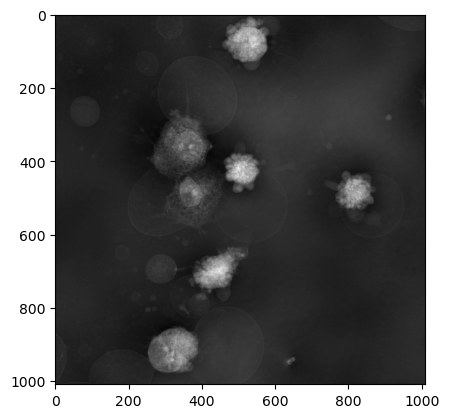

In [76]:
plt.imshow(stack[35], 'gray')

In [86]:
import napari
viewer = napari.Viewer()

In [89]:
from TCFile import TCFile
import numpy as np

path = r"C:\rkka_Projects\cell_death_v1\Data\Hela_Segmentation_test_PWS\TCF\230512.160429.CD95_TNF_Ctr.003.CD95.A1.T001P19.TCF"
file = TCFile(path, '3D')
stack = np.array([np.sum(file[time_idx], axis=0) for time_idx in range(len(file))])
stack.shape

c:\miniconda3\envs\cell\Lib\site-packages\TCFile\TCFile_class.py:190: UserWarning:

You use an experimental file format deprecated.
Update your reconstruction program and rebuild TCF file.



(49, 1009, 1009)

In [78]:
viewer.add_image(good_sparsity_mask)

<Image layer 'good_sparsity_mask [1]' at 0x1c47e508f50>